In [110]:
import pandas as pd
import matplotlib.pyplot as plt

In [111]:
OUT_CSV_NAMES = ["full_id", "crime_type", "crime_confidence", "result_type", "result_confidence"]
RAW_CSV_NAMES = ["court", "old_num", "cnj_num", "judge", "pub_date", "full_id", "file_id", "file_hash", "url"]
CLASSIFIED_DATA_NAMES = ["full_id", "court", "cnj_num", "judge", "pub_date", "crime_type", "crime_confidence", "result_type", "result_confidence"]

CRIME_TYPES = {"None": "Não Classificada", "1": "Outros Crimes", "2": "Crime Patrimonial"}
RESULT_TYPES = {"None": "Não Classificada", "1": "Condenatória", "2": "Absolutória", "3": "Neutra"}

COLORS = {
    "Não Classificada": "Gray",
    "Outros Crimes": "C5",
    "Crime Patrimonial": "C8",
    "Condenatória": "C3",
    "Absolutória": "C2",
    "Neutra": "C1",
}
CRIME_COLORS = ["Gray", "C5", "C8"]
RESULT_COLORS = ["Gray", "C1", "C2", "C3"]

In [112]:
classified = pd.read_csv("../data/output.csv", sep=";", names=OUT_CSV_NAMES)
df = pd.read_csv("../data/data.csv", sep=";", names=RAW_CSV_NAMES)
df = df.drop_duplicates(subset=["full_id"])
df = df[df["full_id"].isin(classified["full_id"])]
df = pd.merge(df, classified, how="inner", on=["full_id", "full_id"])
df = df.filter(CLASSIFIED_DATA_NAMES)
df["crime_type"] = df.crime_type.map(CRIME_TYPES)
df["result_type"] = df.result_type.map(RESULT_TYPES)
df["pub_date"] = pd.to_datetime(df["pub_date"], format="%d/%m/%Y")
df["year_month"] = df["pub_date"].map(lambda fulldate : fulldate.strftime("%m-%Y"))
df = df.replace("None", 0.0)
df = df.astype({"result_confidence": float})
df.head()

,full_id,court,cnj_num,judge,pub_date,crime_type,crime_confidence,result_type,result_confidence,year_month
0,337330f221b9dee180b4ac10ccc6af1e85f712,6,31406851420118130024,LUZIENE MEDEIROS DO NASCIMENTO BARBOSA,2014-02-04,Crime Patrimonial,1.0,Condenatória,1.0,02-2014
1,332858b084099eb20669a7ad4c55c802298b51,6,24686538920138130024,LUZIENE MEDEIROS DO NASCIMENTO BARBOSA,2014-02-03,Crime Patrimonial,1.0,Condenatória,1.0,02-2014
2,339783cb84ddc71d037351ff35dd2296b7726b,6,25710349320048130024,LUZIENE MEDEIROS DO NASCIMENTO BARBOSA,2014-01-31,Crime Patrimonial,1.0,Condenatória,1.0,01-2014
3,326596d77dbddebecae533d1a3ebcd3b444ce4,6,35089512420048130024,LUZIENE MEDEIROS DO NASCIMENTO BARBOSA,2014-01-31,Crime Patrimonial,1.0,Condenatória,1.0,01-2014
4,3255572fa9e54ef0c46810838aa45606b3bbb5,6,26891001720138130024,LUZIENE MEDEIROS DO NASCIMENTO BARBOSA,2014-01-31,Crime Patrimonial,1.0,Condenatória,1.0,01-2014


In [113]:
MIN_DATE = min(df["pub_date"])
MAX_DATE = max(df["pub_date"])

In [114]:
def plot_bar_and_pie(df_series, title, colors):
    fig, axes = plt.subplots(nrows=2, figsize=(12,12))
    fig.suptitle(get_title_with_dates(title))
    ax = df_series.value_counts().sort_values().plot(ax=axes[0], kind="bar", rot=0)
    ax.bar_label(ax.containers[0])
    df_series.value_counts().sort_values().plot.pie(ax=axes[1], autopct="%1.0f%%", colors=colors)
    axes[1].set_ylabel("");

In [115]:
def get_title_with_dates(title, from_date=MIN_DATE, until_date=MAX_DATE):
    return f"{title} - {from_date.year} a {until_date.year}"

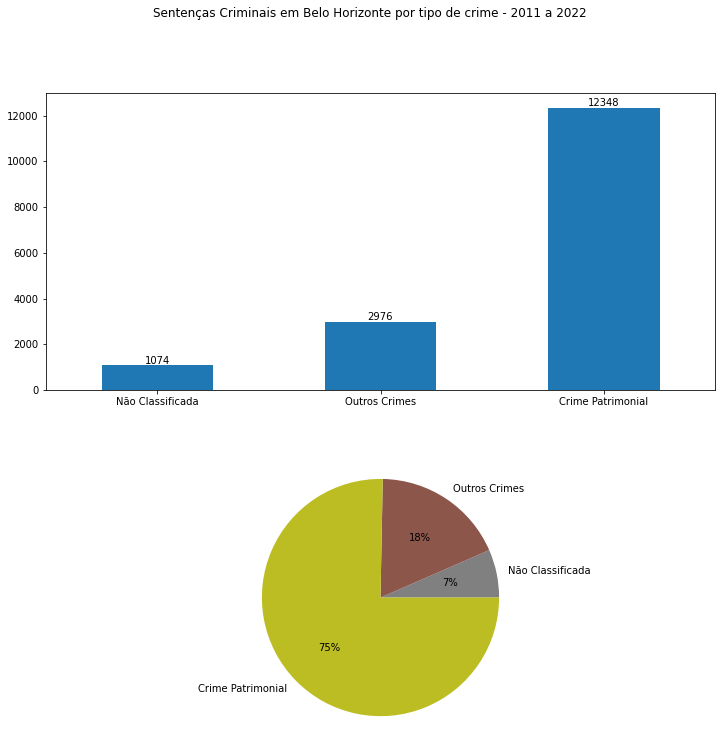

In [116]:
plot_bar_and_pie(df["crime_type"], "Sentenças Criminais em Belo Horizonte por tipo de crime", CRIME_COLORS)

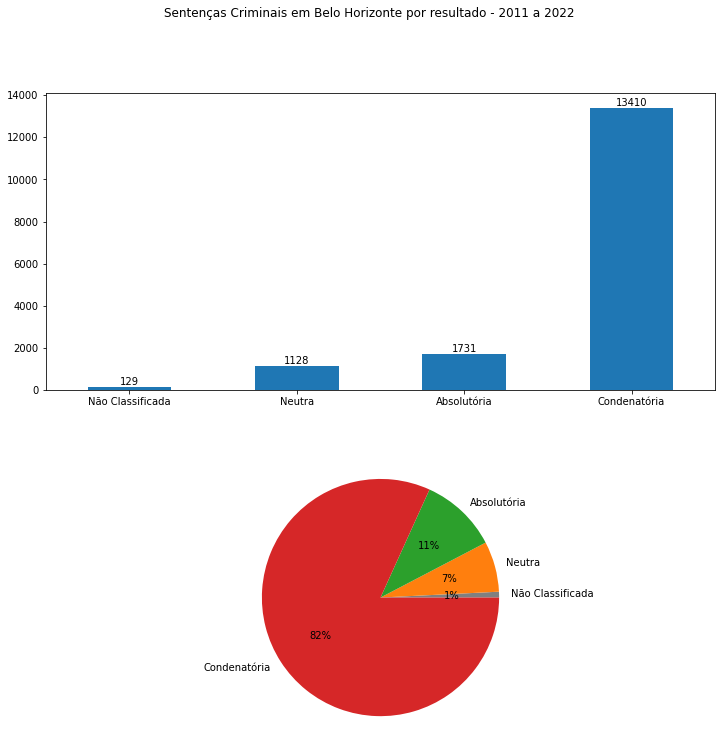

In [117]:
plot_bar_and_pie(df["result_type"], "Sentenças Criminais em Belo Horizonte por resultado", RESULT_COLORS)

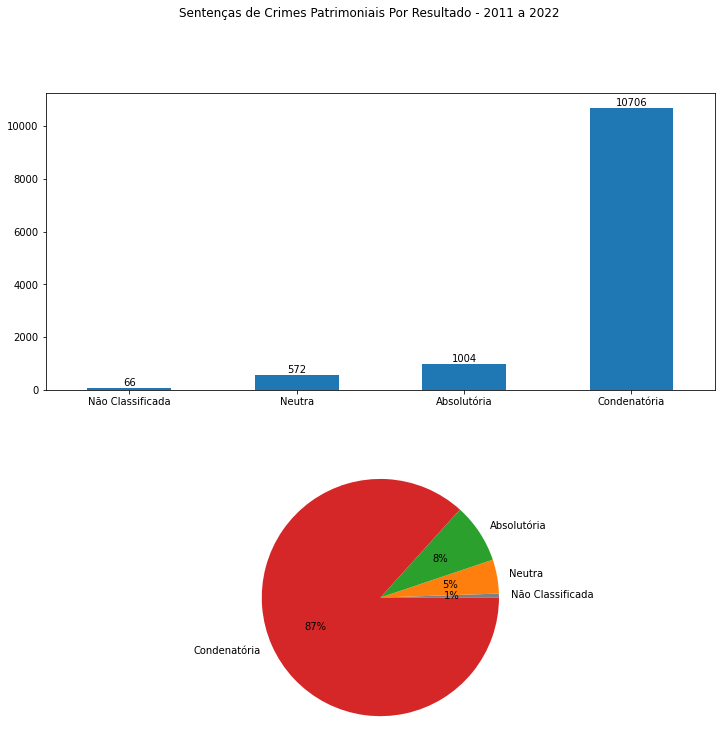

In [118]:
patrimoniais = df[df["crime_type"] == "Crime Patrimonial"]
plot_bar_and_pie(patrimoniais["result_type"], "Sentenças de Crimes Patrimoniais Por Resultado", RESULT_COLORS)


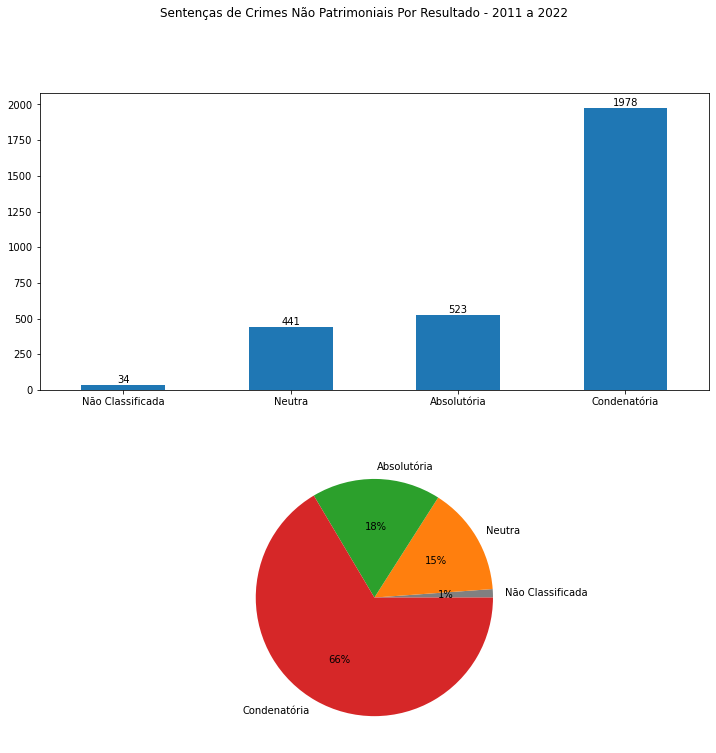

In [119]:
outros = df[df["crime_type"] == "Outros Crimes"]
plot_bar_and_pie(outros["result_type"], "Sentenças de Crimes Não Patrimoniais Por Resultado", RESULT_COLORS)

In [129]:
def plot_court_dist(vara_dist, title):
    vara_df = pd.DataFrame(vara_dist).fillna(0).transpose()
    vara_df = vara_df[["Condenatória", "Absolutória", "Neutra", "Não Classificada"]]
    vara_df = vara_df.div(vara_df.sum(axis=1), axis=0).multiply(100).round()
    ax = vara_df.plot.bar(figsize=(16, 9), legend=True, color=RESULT_COLORS[::-1], rot=0, title=title);
    ax.grid("on", linewidth=0.3)
    for container in ax.containers:
        ax.bar_label(container)

In [130]:
def get_court_dist(df):
    vara_dist = {}
    for vara in set(df["court"]):
        vara_df = df[df["court"] == vara]
        vara_dist[vara] = vara_df["result_type"].value_counts()
    return vara_dist

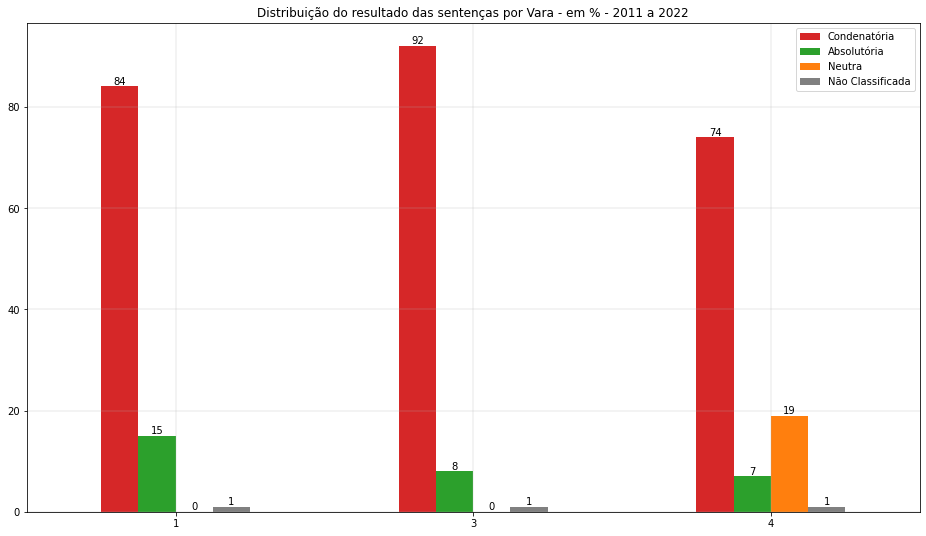

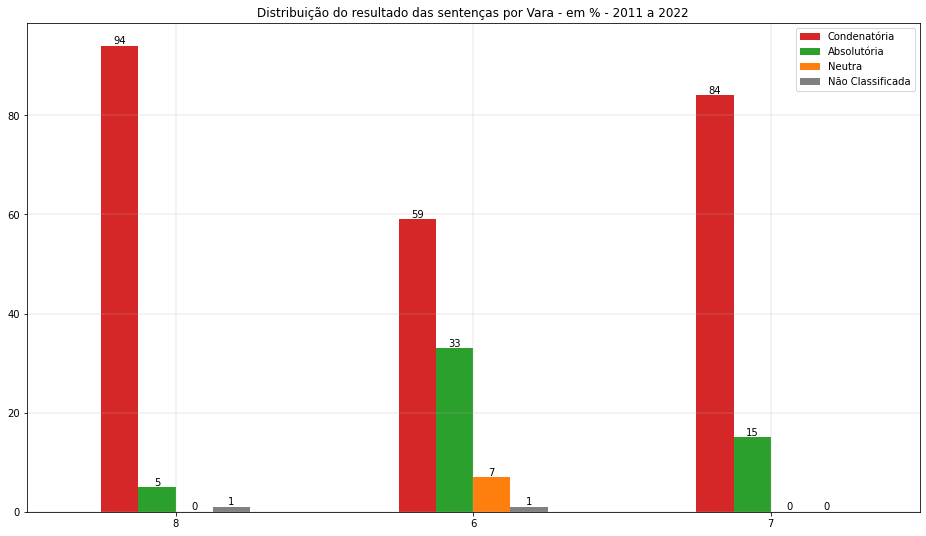

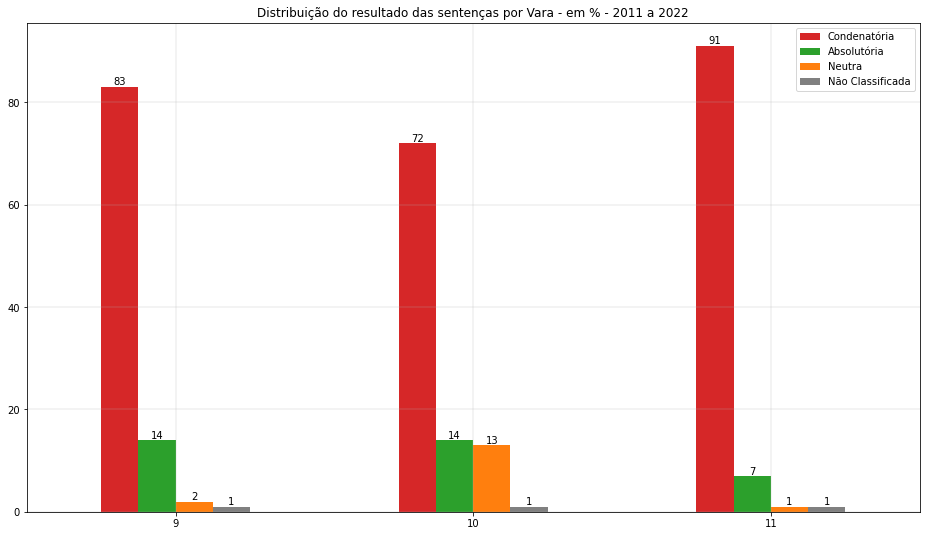

In [133]:
df_varas_1 = df[df["court"].isin([1, 3, 4])]
df_varas_2 = df[df["court"].isin([6, 7, 8])]
df_varas_3 = df[df["court"].isin([9, 10, 11])]
vara_dist_1 = get_court_dist(df_varas_1)
vara_dist_2 = get_court_dist(df_varas_2)
vara_dist_3 = get_court_dist(df_varas_3)
plot_court_dist(vara_dist_1, title=f"Distribuição do resultado das sentenças por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")
plot_court_dist(vara_dist_2, title=f"Distribuição do resultado das sentenças por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")
plot_court_dist(vara_dist_3, title=f"Distribuição do resultado das sentenças por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")

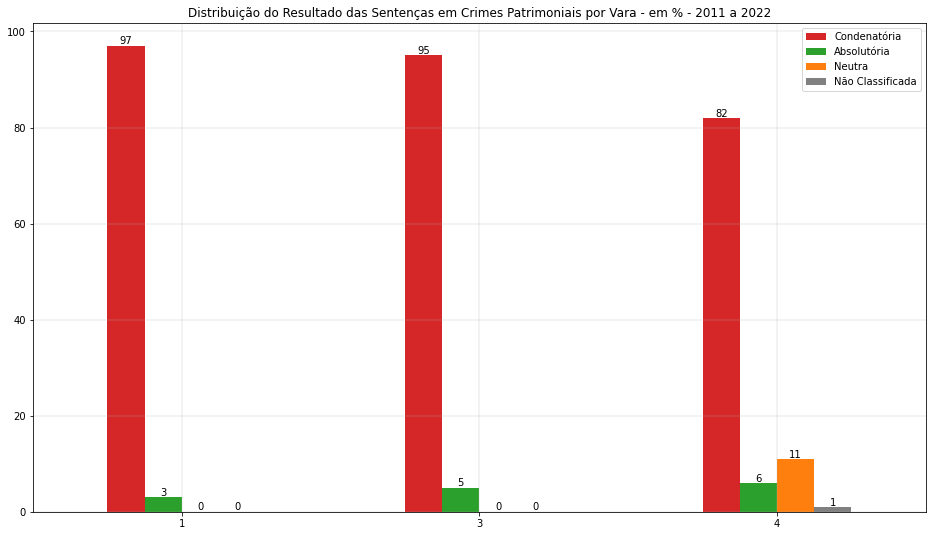

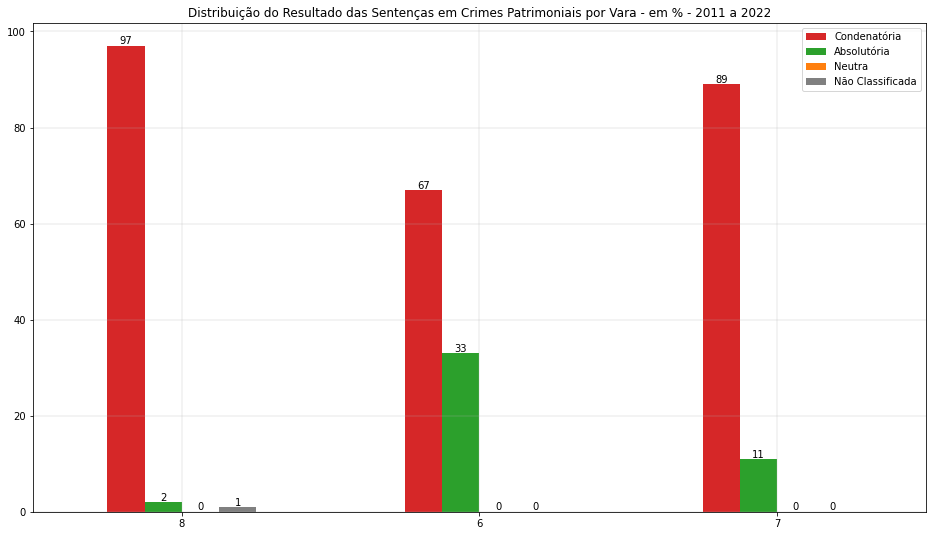

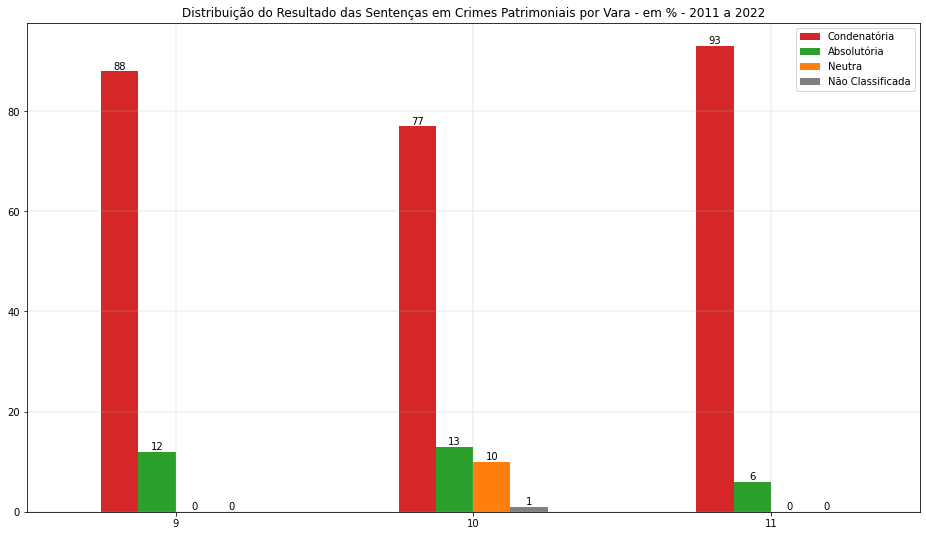

In [134]:
patri_varas_1 = patrimoniais[patrimoniais["court"].isin([1, 3, 4])]
patri_varas_2 = patrimoniais[patrimoniais["court"].isin([6, 7, 8])]
patri_varas_3 = patrimoniais[patrimoniais["court"].isin([9, 10, 11])]
patrimoniais_dist_1 = get_court_dist(patri_varas_1)
patrimoniais_dist_2 = get_court_dist(patri_varas_2)
patrimoniais_dist_3 = get_court_dist(patri_varas_3)
plot_court_dist(patrimoniais_dist_1, title=f"Distribuição do Resultado das Sentenças em Crimes Patrimoniais por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")
plot_court_dist(patrimoniais_dist_2, title=f"Distribuição do Resultado das Sentenças em Crimes Patrimoniais por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")
plot_court_dist(patrimoniais_dist_3, title=f"Distribuição do Resultado das Sentenças em Crimes Patrimoniais por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")

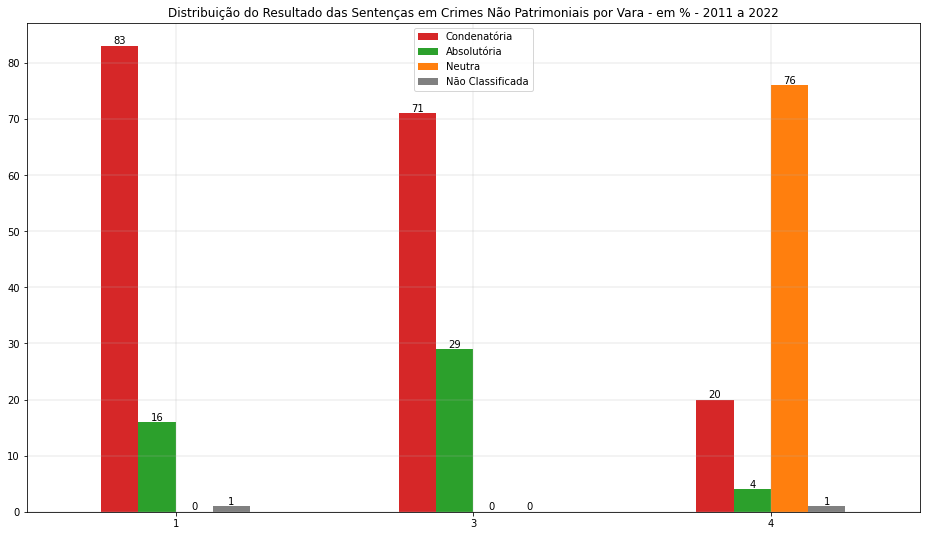

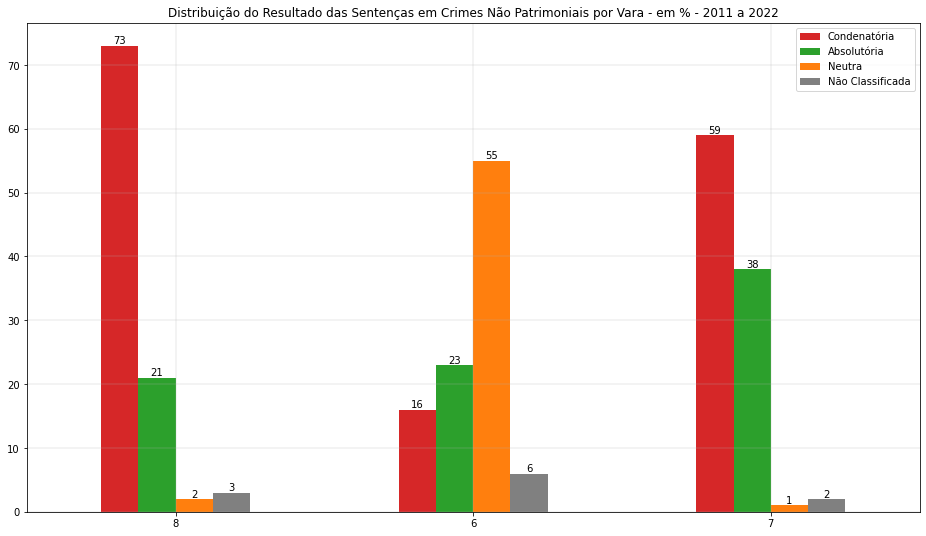

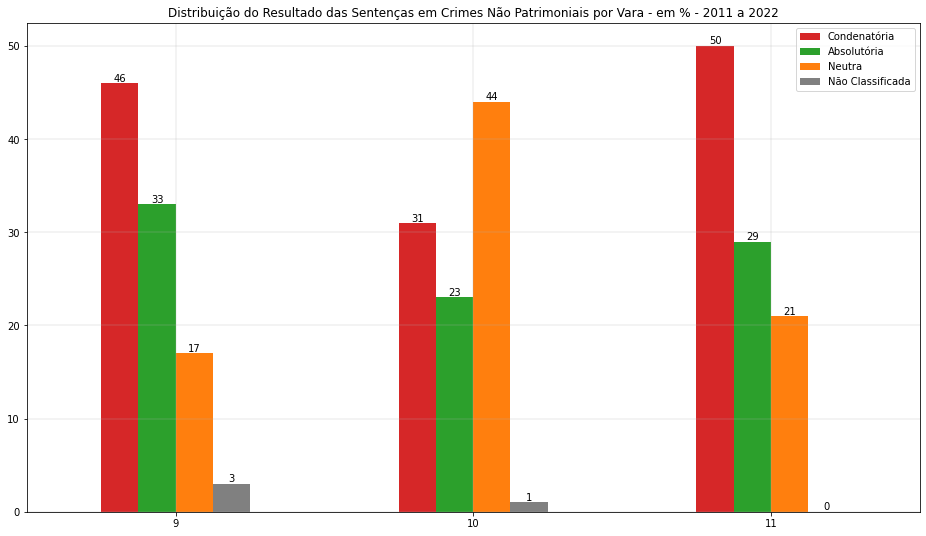

In [135]:
outros_varas_1 = outros[outros["court"].isin([1, 3, 4])]
outros_varas_2 = outros[outros["court"].isin([6, 7, 8])]
outros_varas_3 = outros[outros["court"].isin([9, 10, 11])]
outros_dist_1 = get_court_dist(outros_varas_1)
outros_dist_2 = get_court_dist(outros_varas_2)
outros_dist_3 = get_court_dist(outros_varas_3)
plot_court_dist(outros_dist_1, title=f"Distribuição do Resultado das Sentenças em Crimes Não Patrimoniais por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")
plot_court_dist(outros_dist_2, title=f"Distribuição do Resultado das Sentenças em Crimes Não Patrimoniais por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")
plot_court_dist(outros_dist_3, title=f"Distribuição do Resultado das Sentenças em Crimes Não Patrimoniais por Vara - em % - {MIN_DATE.year} a {MAX_DATE.year}")

In [ ]:
df_judges = df.loc[:, ["judge", "crime_type", "result_type"]]
df_judges = df_judges[df_judges["result_type"] != "Não Classificada"]
df_judges["result_type"] = df_judges["result_type"].map(lambda x : 1 if x == "Condenatória" else 0)

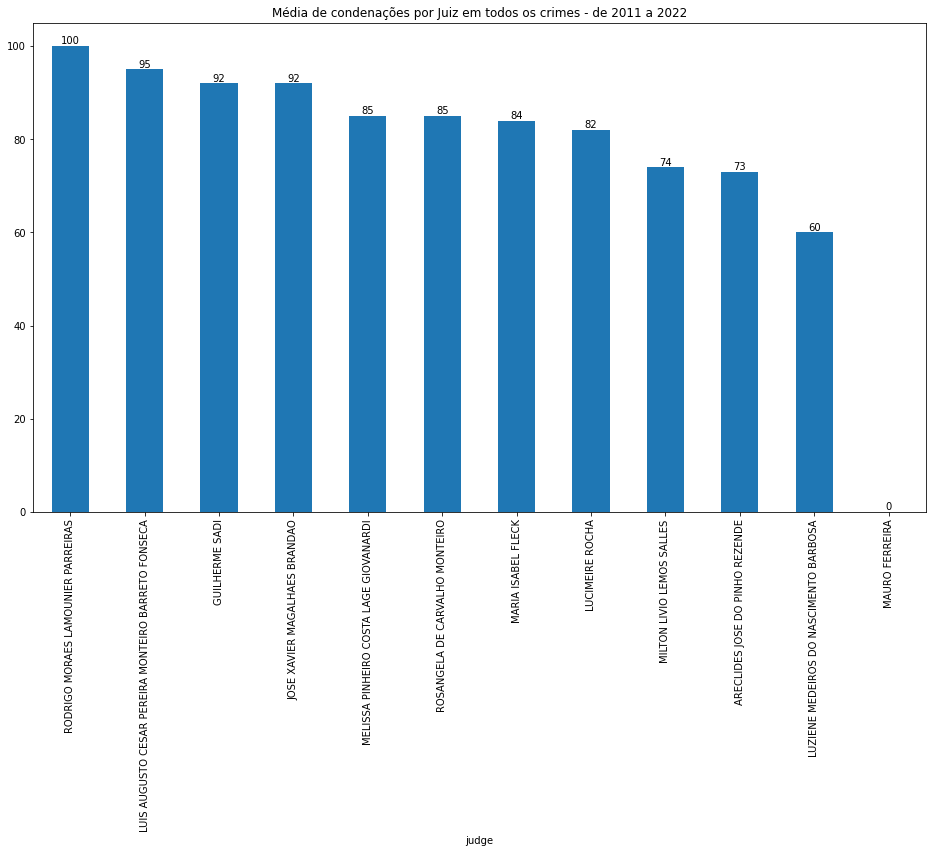

In [ ]:
df_judges_all = df_judges[["judge", "result_type"]]
ax = df_judges_all.groupby("judge") \
                    .mean() \
                    .multiply(100) \
                    .round() \
                    .sort_values(by="result_type", ascending=False) \
                    .plot(kind="bar", figsize=(16, 9), legend=False, title=f"Média de condenações por Juiz em todos os crimes - de {MIN_DATE.year} a {MAX_DATE.year}")
ax.bar_label(ax.containers[0]);

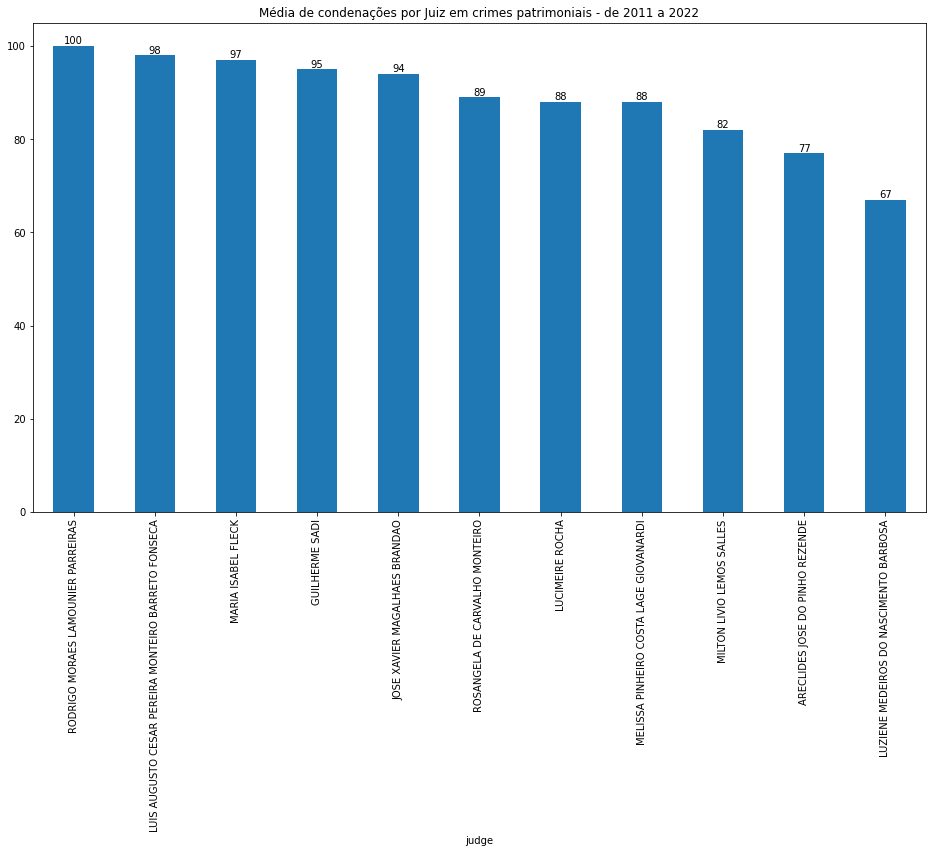

In [ ]:
df_judges_patri = df_judges[df_judges["crime_type"] == "Crime Patrimonial"]
df_judges_patri = df_judges_patri[["judge", "result_type"]]
ax = df_judges_patri.groupby("judge") \
                    .mean() \
                    .multiply(100) \
                    .round() \
                    .sort_values(by="result_type", ascending=False) \
                    .plot(kind="bar", figsize=(16, 9), legend=False, title=f"Média de condenações por Juiz em crimes patrimoniais - de {MIN_DATE.year} a {MAX_DATE.year}")
ax.bar_label(ax.containers[0]);

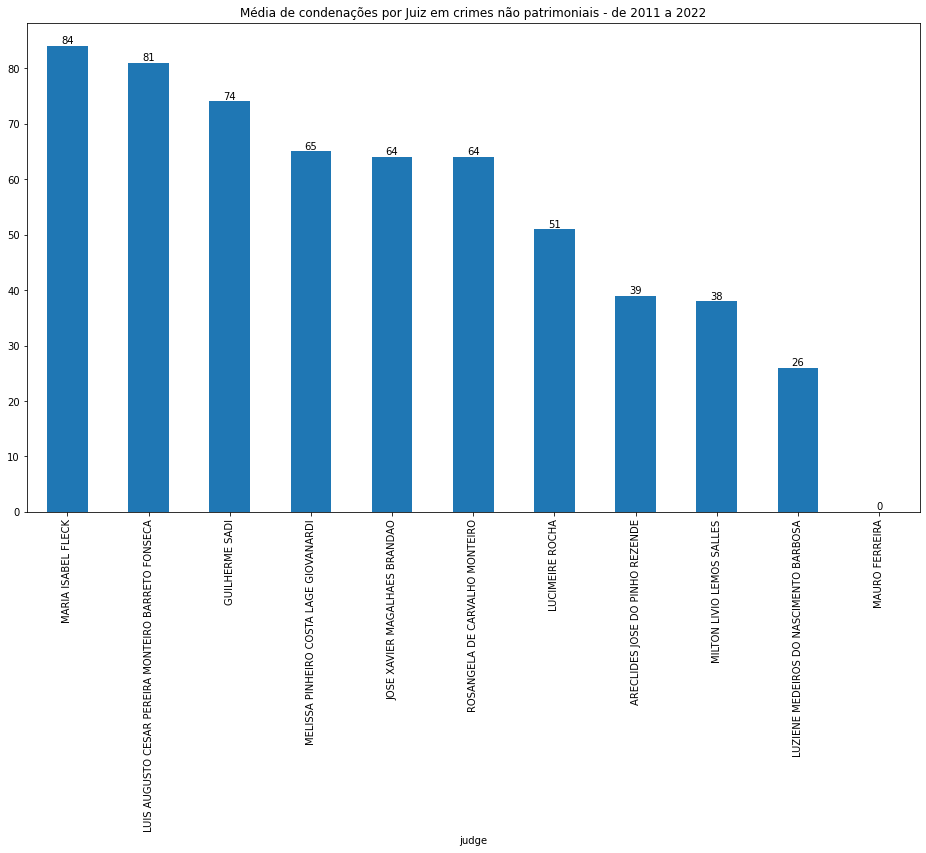

In [ ]:
df_judges_outros = df_judges[df_judges["crime_type"] != "Crime Patrimonial"]
df_judges_outros = df_judges_outros[["judge", "result_type"]]
ax = df_judges_outros.groupby("judge") \
                    .mean() \
                    .multiply(100) \
                    .round() \
                    .sort_values(by="result_type", ascending=False) \
                    .plot(kind="bar", figsize=(16, 9), legend=False, title=f"Média de condenações por Juiz em crimes não patrimoniais - de {MIN_DATE.year} a {MAX_DATE.year}")
ax.bar_label(ax.containers[0]);